import urllib.request

url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
week_nums = [190504, 190511, 190518, 190525, 190601, 190608, 190615, 190622, 190629, 190706, 190713, 190720, 190727]

for week_num in week_nums:
    urllib.request.urlretrieve(f"http://web.mta.info/developers/data/nyct/turnstile/turnstile_{week_num}.txt",
                               f"data/turnstile_{week_num}.txt")

In [104]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

engine = create_engine("sqlite:///mta.db")
all_data = pd.read_sql('SELECT * FROM mta_data;', engine)

In [11]:
df = all_data

In [12]:
# Need to change columns to row-index 0
#df.rename(columns = df.loc[0], inplace =True)

# Remove row 0
#df = df.drop([0], inplace=True)

#Drop dups
df.drop_duplicates(inplace=True)


In [14]:
# Need to convert EXITS column field11 into numeric type
df['EXITS'] = df['EXITS'].astype(np.float64)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2684040 entries, 1 to 2684040
Data columns (total 11 columns):
 #   Column    Dtype  
---  ------    -----  
 0   C/A       object 
 1   UNIT      object 
 2   SCP       object 
 3   STATION   object 
 4   LINENAME  object 
 5   DIVISION  object 
 6   DATE      object 
 7   TIME      object 
 8   DESC      object 
 9   ENTRIES   object 
 10  EXITS     float64
dtypes: float64(1), object(10)
memory usage: 245.7+ MB


In [16]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,00:00:00,REGULAR,0007035249,2384833.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,04:00:00,REGULAR,0007035269,2384840.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,08:00:00,REGULAR,0007035292,2384875.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,12:00:00,REGULAR,0007035392,2384951.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,16:00:00,REGULAR,0007035651,2385020.0


In [44]:
# Need to find the max(EXITS) for each (SCP) by DATE
#This excludes the EXITS count from TIME 20:00-23:59 each day. The data from this date frame is not as relevant to my company of interest.
#The EXITS count during this time is likely minimal. Additionally, scooters are reclaimed at night to charge to be redeployed the next morning.
#I used .shift method with PREV_EXITS initially. However, for C/A==S101A, SCP==01-00-03 between 05/01/2019 and 05/02/2019 there was an unexplained jump from 432 to 1078346838.
max_exit = df.groupby(['C/A','SCP','DATE'])[['EXITS']].max()

In [45]:
# Need to find the min(EXITS) for each (SCP) by DATE
min_exit = df.groupby(['C/A','SCP','DATE'])[['EXITS']].min()

In [90]:
#Merging total scp exits data into one df, on matching SCP column
total_scp_exit = pd.merge(max_exit, min_exit, on=['C/A','SCP','DATE'])
total_scp_exit.head()

EXITS_x    EXITS_y
C/A  SCP      DATE                            
A002 02-00-00 04/27/2019  2385070.0  2384833.0
              04/28/2019  2385240.0  2385087.0
              04/29/2019  2385732.0  2385256.0
              04/30/2019  2386197.0  2385765.0
              05/01/2019  2386673.0  2386229.0

In [91]:
# total_scp_exits = max-min for each turnstile SCP per DATE
total_scp_exit['exits_per_day'] = total_scp_exit['EXITS_x']-total_scp_exit['EXITS_y']
total_scp_exit.head()

EXITS_x    EXITS_y  exits_per_day
C/A  SCP      DATE                                           
A002 02-00-00 04/27/2019  2385070.0  2384833.0          237.0
              04/28/2019  2385240.0  2385087.0          153.0
              04/29/2019  2385732.0  2385256.0          476.0
              04/30/2019  2386197.0  2385765.0          432.0
              05/01/2019  2386673.0  2386229.0          444.0

In [125]:
#There are some large inexplicable jumps in the EXITS count
total_scp_exit.sort_values(['exits_per_day'], ascending=False)

EXITS_x  EXITS_y  exits_per_day
C/A   SCP      DATE                                       
PTH13 00-00-03 06/11/2019  19917.0      3.0        19914.0
PTH07 00-00-00 06/11/2019  19924.0     14.0        19910.0
PTH05 00-04-08 06/10/2019  19560.0      8.0        19552.0
PTH16 01-01-08 07/11/2019  19188.0     20.0        19168.0
PTH18 01-01-02 05/09/2019  19074.0      1.0        19073.0
...                            ...      ...            ...
N203  00-05-00 04/29/2019      0.0      0.0            0.0
               04/30/2019      0.0      0.0            0.0
               05/01/2019      0.0      0.0            0.0
               05/02/2019      0.0      0.0            0.0
TRAM2 00-05-01 07/26/2019    383.0    383.0            0.0

[441498 rows x 3 columns]

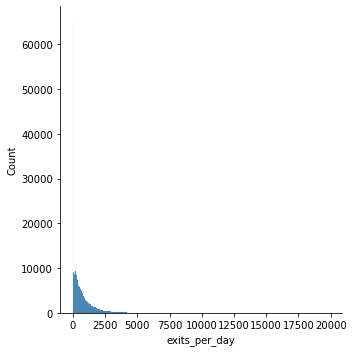

In [110]:
sns.displot(total_scp_exit[(total_scp_exit.exits_per_day <20000)].exits_per_day)
#This shows distribution of exits_per_day values

In [124]:
#Remove exits_per_day values > 20000
total_scp_exit = total_scp_exit[(total_scp_exit.exits_per_day <20000)]

In [112]:
#Find AVG EXITS per day per SCP.
avg_daily_exit = total_scp_exit.groupby(['C/A','SCP'])[['exits_per_day']].mean()
avg_daily_exit.head()

exits_per_day
C/A  SCP                    
A002 02-00-00     346.791209
     02-00-01     203.901099
     02-03-00    1485.406593
     02-03-01    1522.923077
     02-03-02    1157.890110

In [119]:
#Group by C/A and return the mean of daily exits of all SCP per C/A
station_daily = avg_daily_exit.groupby(['C/A'])[['exits_per_day']].mean()
station_daily.head(10)

,exits_per_day
C/A,
A002,523.565934
A006,871.822802
A007,530.265690
A010,768.451923
A011,2987.151648
A013,894.094017
A015,702.142857
A016,455.487912
A021,2150.969780


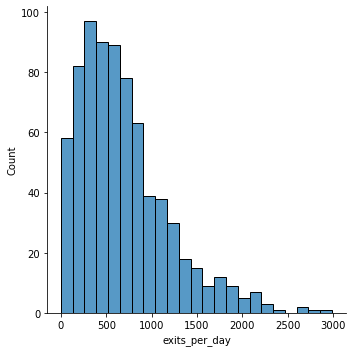

In [121]:
sns.displot(station_daily.exits_per_day)

In [116]:
#Sorting DESC to find top 5 stations
station_daily = station_daily.sort_values(by=['exits_per_day'],ascending=False).round(decimals=2)
station_daily.head(5)

,exits_per_day
C/A,
A011,2987.15
R216,2785.67
R238,2667.11
R135,2650.36
N100,2447.81


In [ ]:
#I could also produce another metric for total avg exits for the past 4 weeks, updated 